# Plot CCF over 20 years

2023.3.25 Kurama Okubo

This notebook plots the result of CCF.

- 2023.4.17 update to plot 3 components tiles
- 2023.4.27 update to implement median mute for reference stack

In [1]:
import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from IPython.display import display, Math
import seaborn as sns 

import numpy as np
import pandas as pd
import h5py
import pickle

import matplotlib as mpl

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

In [2]:
#---Parameters---#
fidir = "../data_npz"
freqkey = "0.9-1.2"
output_imgdir = "../figure/ccf_master"

starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)

refstack_starttime = datetime.datetime(2010, 1, 1)
refstack_endtime = datetime.datetime(2022, 6, 1)

if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)

In [3]:
cpalette=np.array(sns.color_palette("colorblind"))[:]
lc_lin = cpalette[2]

In [4]:
# sns.color_palette("colorblind")

In [5]:
# Read BP stations
loc_table = "./BP_gmap-stations.txt"
df_raw = pd.read_csv(loc_table, skiprows=3, header=None, sep = '|')
stationlist = np.sort(df_raw[1].values)

In [6]:
stationlist
Nstation = len(stationlist)
# make station pairs

stationpair_list = []

for i in range(Nstation):
    jinit = i
    for j in range(jinit, Nstation):
        sta1 = stationlist[i]
        sta2 = stationlist[j]
        stationpair_list.append(f"BP.{sta1}-BP.{sta2}")

In [7]:
complist = ["11","12","13","21","22","23","31","32","33"]
complist

['11', '12', '13', '21', '22', '23', '31', '32', '33']

In [90]:
# #---develop median mute---#
# cc_medianmute_max = 3.0
# cc_medianmute_min = 0.1

# stationpair = 'BP.EADB-BP.EADB'
# comp = '22'
# fi_stachanpair = f"{stationpair}-{comp}"
# D = np.load(fidir+f"/corrdata_{fi_stachanpair}_{freqkey}.npz")
# lags = D["lags"]
# t = D["t"]
# corr_raw = D["corr"]

# cc_maxamp = np.max(np.abs(corr_raw), axis=0)
# cc_medianamp = np.nanmedian(cc_maxamp)
# cc_medianamp
# inds = np.where((cc_maxamp <= cc_medianmute_max*cc_medianamp) & (cc_medianmute_min*cc_medianamp <= cc_maxamp))[0]
# stack =  np.mean(corr_raw[:, inds], axis=1)
# plt.plot(stack)

In [95]:
def get_plotcorrdata(stationpair, comp):

    fi_stachanpair = f"{stationpair}-{comp}"
    D = np.load(fidir+f"/corrdata_{fi_stachanpair}_{freqkey}.npz")
    lags = D["lags"]
    t = D["t"]
    corr_raw = D["corr"]
    linstack_raw = D["linstack"]
    codainit = D["codainit"]
    codaend = D["codaend"]

    # compute abs_max the corr data and linear stacked data
    max_corr_raw = np.max(np.abs(corr_raw), axis=0)
    # avoid zero division when the corr data is all zero.
    # This happens when the sparse data sets are correlated, but it is only a few cases.
    max_corr_raw[max_corr_raw==0] = np.nan # replace that row as nan 
    corr = corr_raw / max_corr_raw
    linstack = linstack_raw / np.max(np.abs(linstack_raw), axis=0)

    # convert tvec to datetime
    # NOTE: The time is not always start from 0H00M, which occurs due to the lack of hourly CCF when computing daily-stacked CCF.
    uniform_tvec = np.array([datetime.datetime.utcfromtimestamp(x) for x in t])

    # compute refstack:
    # NOTE: linstack is done from 2002-1-1 to 2022-6-1 during the conversion with Julia script.
    # We add one more reference stack corresponding to the one used in the actual postprocess.
    ref_tind = np.where((refstack_starttime <= uniform_tvec) & (uniform_tvec <= refstack_endtime))[0]
    # compute the reference stack
    # Update: implement the mediean mute
    corr_ref = corr_raw[:, ref_tind]
    
    cc_maxamp = np.max(np.abs(corr_ref), axis=0)
    cc_medianamp = np.nanmedian(cc_maxamp)
    median_inds = np.where((cc_maxamp <= cc_medianmute_max*cc_medianamp) & (cc_medianmute_min*cc_medianamp <= cc_maxamp))[0]
    refstack_raw =  np.mean(corr_ref[:, median_inds], axis=1)
#     refstack_raw = np.mean(corr_raw[:, ref_tind], axis=1)
    refstack = refstack_raw / np.max(np.abs(refstack_raw), axis=0)

    return (lags, uniform_tvec, codainit, codaend, corr, linstack, refstack)


In [96]:
stationpair = stationpair_list[0]
sta1, sta2 = stationpair.split("-")
sta1 = sta1.split(".")[-1]
sta2 = sta2.split(".")[-1]

In [97]:
# plot parameter
vmin = -1.0
vmax = 1.0
tmax = 50
gcm = "seismic"

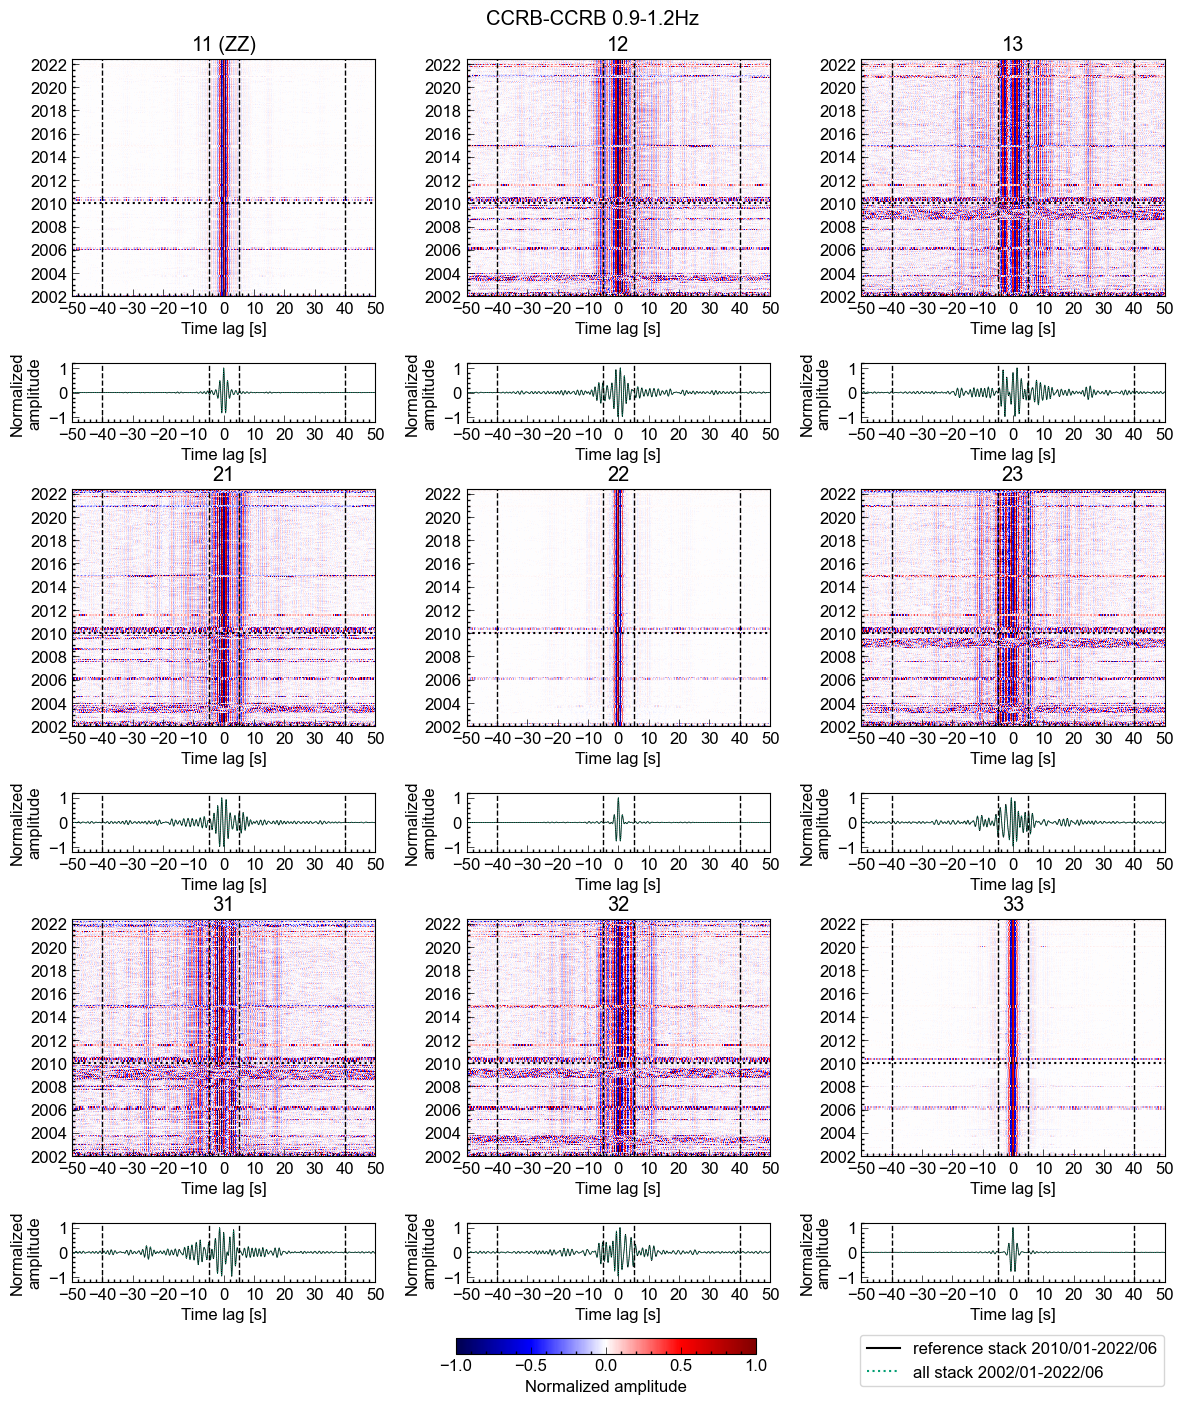

In [99]:
fig, axs = plt.subplots(6, 3, figsize=(12, 14.3), sharex=False, gridspec_kw={'height_ratios': [4, 1, 4, 1, 4, 1]})
fig.suptitle(f"{sta1}-{sta2} {freqkey}Hz");

# Loop with 3 channel correlations    
for comp in complist:

    comp1, comp2 = comp
    comp1 = int(comp1)
    comp2 = int(comp2)

    fi_stachanpair =  f"{stationpair}-{comp}"
    if not os.path.isfile(fidir+f"/corrdata_{fi_stachanpair}_{freqkey}.npz"):
        print(f"{fi_stachanpair} file not exists. skipping.")
        continue

    lags, uniform_tvec, codainit, codaend, corr, linstack, refstack = get_plotcorrdata(stationpair, f"{comp1}{comp2}")

    p1, p2 = [2*(comp1-1), comp2-1]
    
    # plot contour
    axs[p1, p2].pcolormesh(lags, uniform_tvec, np.transpose(corr), cmap=gcm, vmin=vmin, vmax=vmax, rasterized=True, )

    axs[p1, p2].set_xlim([-tmax, tmax])
    axs[p1, p2].set_xticks(np.linspace(-tmax, tmax, 11))
    axs[p1, p2].set_ylim([starttime, endtime])

    if f"{comp1}{comp2}" == "11":
        subplottitle = "11 (ZZ)"
    else:
        subplottitle = f"{comp1}{comp2}"

    axs[p1, p2].set_title(subplottitle)
    loc = mdates.YearLocator(2)
    axs[p1, p2].yaxis.set_major_locator(loc)
    fmt = mdates.DateFormatter('%Y')
    axs[p1, p2].yaxis.set_major_formatter(fmt)
    axs[p1, p2].set_xlabel("Time lag [s]")

    # coda window
    for i in range(2):
        axs[p1, p2].axvline(codainit[i], ls="--", c='k', lw=1.0)
        axs[p1, p2].axvline(codaend[i], ls="--", c='k', lw=1.0)

    # reference window
    axs[p1, p2].axhline(refstack_starttime, ls=":", c='k', lw=1.5)
    axs[p1, p2].axhline(refstack_endtime, ls=":", c='k', lw=1.5)

    axs[p1+1, p2].plot(lags, refstack, "k-", lw=0.6)
    axs[p1+1, p2].plot(lags, linstack, ":", c=lc_lin, lw=0.6)
    axs[p1+1, p2].set_xlim([-tmax, tmax])
    axs[p1+1, p2].set_ylim([-1.2, 1.2])
    axs[p1+1, p2].set_xticks(np.linspace(-tmax, tmax, 11))
    axs[p1+1, p2].set_xlabel("Time lag [s]")
    axs[p1+1, p2].set_ylabel("Normalized\namplitude")

    for i in range(2):
        axs[p1+1, p2].axvline(codainit[i], ls="--", c='k', lw=1.0)
        axs[p1+1, p2].axvline(codaend[i], ls="--", c='k', lw=1.0)
        
    
fig.tight_layout(rect=[0,0,1,1.0])
plt.subplots_adjust(hspace=0.45, wspace=0.3)

for i in [0, 2, 4]:
    for j in range(3):
        pos1 = axs[i, j].get_position() # get the original position 
        pos2 = [pos1.x0, 0.983*pos1.y0,  pos1.width, pos1.height] 
        axs[i, j].set_position(pos2) # set a new position

fig.subplots_adjust(bottom=0.09)
cbar_ax = fig.add_axes([0.0615, 0.04, 0.9, 0.07])
cbar_ax.set_axis_off()
# (left, bottom, width, height)
normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=gcm),
                 orientation='horizontal', ax=cbar_ax, location = 'bottom',
                 label="Normalized amplitude")

# add text box for the annotation of stacked lines
legend_ax = fig.add_axes([0.7, 0.025, 0.3, 0.02])
legend_ax.plot([], [], "k-", label=f'reference stack {refstack_starttime.strftime("%Y/%m")}-{refstack_endtime.strftime("%Y/%m")}') # dummy data for legend
legend_ax.plot([], [], ":", c=lc_lin, label=f'all stack {starttime.strftime("%Y/%m")}-{endtime.strftime("%Y/%m")}')
legend_ax.legend(loc=10)
legend_ax.set_axis_off()

foname = (output_imgdir+"/ccf_master_allcomp_{}_{}Hz.png".format(stationpair, freqkey))
plt.savefig(foname, dpi=150)
# plt.clf()
# plt.close()
